In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from model_prediction import Replicator
from pneumococcus_data import data_observation
from compute_dynamics import *
from Jacobian import jacobian_func

In [2]:
# import Particle Swarm Optimization algorithm
from PSO_algo import Particle
from PSO_algo import PSO

### Description
The number of strains reported in Mozambique is $45$; and the ratio of single to co-colonization is $\mu = 16.8$. \
We need to estimate the matrix $45 \times 45$ $\left(\alpha_{ij}\right)$ of Mozambique. Since $\mu$ of Mozambique is large, we estimate parameters such that the data observation (Mozambique prevalence) is the solution of the replicator dynamics at time $\tau=50$ with the same frequencies for all initial values $z_N(0)$, $1 \leq N \leq 45$, as what we did for Brazil and Denmark. The estimation process is as follows: \
i) From $\alpha_{ij}$'s estimated in Nepal-Case 1, Brazil and Denmark, in Mozambique's $\alpha_{ij}$ matrix, we insert $1611$ values of $\alpha_{ij}$'s already estimated in three previous processes. \
ii) Use PSO algorithm to estimate $414$ remaining $\alpha_{ij}$'s such that the error between data observation $z^*_{\text{Mozambique}}$ and the solution of replicator dynamics with the $\Lambda$ for Mozambique, at time $\tau=50$, $\mathbf{z}(50)$ attains its minimum. \
In PSO algorithm, we choose the range $\left[-10, 10\right]$ for these $414$ $\alpha_{ij}$'s.

In [3]:
# data observation from 5 countries
Iran, Denmark, Brazil, Nepal, Mozambique = data_observation()

# import name of serotypes and their frequencies from Mozambique
strain_number = len(Mozambique.strain) #=45
Mozambique_strain = np.array(Mozambique.strain)
Mozambique_cases = np.array(Mozambique.cases)

#ratio of single to co-colonization prevalence: mu value of Mozambique
mu = 16.8

# import Nepal alpha & data
Nepal_alpha = np.loadtxt(open("Nepal_alpha.txt","rb"), delimiter = ",", skiprows = 0)
Nepal_strain = np.array(Nepal.strain)

#import Brazil alpha & data
Brazil_alpha = np.loadtxt(open("Brazil_alpha.txt","rb"), delimiter = ",", skiprows = 0)
Brazil_strain  = np.array(Brazil.strain)

#import Denmark alpha & data
Denmark_alpha = np.loadtxt(open("Denmark_alpha.txt","rb"), delimiter = ",", skiprows = 0)
Denmark_strain = np.array(Denmark.strain)

In [4]:
# initiate matrix Mozambique_alpha
Mozambique_alpha = np.ones((strain_number, strain_number))*50

#In Mozambique alpha matrix, find the positions of alpha_ij already estimated before in Nepal, Brazil, Denmark and fills with these values
for xM, strain_xM in enumerate(Mozambique_strain):
    for yM, strain_yM in enumerate(Mozambique_strain):
        
        #insert from Nepal
        find_xNepal = np.where(Nepal_strain == strain_xM)
        index_xNepal = find_xNepal[0]

        find_yNepal = np.where(Nepal_strain == strain_yM)
        index_yNepal = find_yNepal[0]

        #insert from Brazil
        find_xBrazil = np.where(Brazil_strain == strain_xM)
        index_xBrazil = find_xBrazil[0]

        find_yBrazil = np.where(Brazil_strain == strain_yM)
        index_yBrazil = find_yBrazil[0]

        #insert from Denmark
        find_xDenmark = np.where(Denmark_strain == strain_xM)
        index_xDenmark = find_xDenmark[0]

        find_yDenmark = np.where(Denmark_strain == strain_yM)
        index_yDenmark = find_yDenmark[0]


        if index_xBrazil.size > 0 and index_yBrazil.size > 0:
            Mozambique_alpha[xM, yM] = Brazil_alpha[index_xBrazil, index_yBrazil]
        elif index_xNepal.size > 0 and index_yNepal.size > 0:
            Mozambique_alpha[xM, yM] = Nepal_alpha[index_xNepal, index_yNepal]
        elif index_xDenmark.size > 0 and index_yDenmark.size > 0:
            Mozambique_alpha[xM, yM] = Denmark_alpha[index_xDenmark, index_yDenmark]

np.savetxt('fix_alpha_Mozambique.txt', Mozambique_alpha, delimiter = ',')

In [5]:
#find the length of vector that we need to fit the matrix Mozambique alpha
length = 0

for i in range(0, strain_number):
    for j in range(0, strain_number):
        if Mozambique_alpha[i,j] > 49:
            length += 1

print(length)
#so we need to fit the matrix Mozambique

414


In [6]:
#find the coordinate of missing alpha_ij in Mozambique alpha_matrix
position = []

for i in range (0, strain_number):
    for j in range (0, strain_number):
        if Mozambique_alpha[i,j] > 49:
            position.append(np.array([i,j]))

In [7]:
#initial value
u0 = (1/strain_number)*np.ones(strain_number)

#cost function for PSO
def func(vector):
    # insert alpha vector to Mozambique_alpha
    alpha_matrix = np.loadtxt(open("fix_alpha_Mozambique.txt","rb"), delimiter = ",", skiprows = 0)
    for i in range (0, length):
        coordinate = position[i]
        alpha_matrix[coordinate[0], coordinate[1]] = vector[i]

    #compute invasion fitness matrix
    lambd = np.zeros((strain_number, strain_number))
    for i in range (0, strain_number):
        for j in range (0, strain_number):
            lambd[i][j] = mu*(alpha_matrix[j][i] - alpha_matrix[i][j]) + alpha_matrix[j][i] - alpha_matrix[j][j]

    # compute the predicted frequencies, i.e. the solution of replicator equations at t = 50
    solution = Replicator(strain_number, lambd, 50, u0)
    
    # compute the error between observation data and predictied prevalence
    err = np.linalg.norm(solution - Mozambique_cases)

    return err

In [8]:
# RUN PSO algo
# initial starting location [x1,x2...]
initial = [0]*length
# print(func(initial))

#time consuming: ~24h

# input bounds [(x1_min,x1_max),(x2_min,x2_max)...]
bounds = []
for i in range (0, length):
    bounds.append(np.array([-10, 10]))
bounds = np.array(bounds)

#run the algorithm
PSO(func, initial, bounds, num_particles = 1800, maxiter = 4000)

FINAL:
[1.5020975527801033, 1.1216009190924967, -0.20316405641455648, -0.846652653069612, -0.24433994805048453, -4.48173872145764, -0.23591091631519848, 1.7100257102404268, 0.09425381788533832, -1.3242241510325734, -1.1385789282244283, 4.537174395419724, 3.0495995780533884, -0.11509755865986972, 0.47116862257682146, 0.07307863020665852, 0.949813085755314, 3.444829105479853, 0.0459107877718961, -3.324259365468589, -1.3554876742690845, 0.6387184097243774, -0.9773939550017807, 2.023041324893019, -2.421152179153222, 1.643275344882408, 1.8984852171929596, 0.3735335826107064, -0.09063655155559645, 2.0423702977451637, -2.402114534713989, -0.01643433024435039, -3.016782521519054, -1.0240073716847373, 1.504806242288193, -0.4449734328338504, 0.5864509632707504, 1.3933608236005288, 0.12752715018203528, 1.2086853252582395, -0.8300310851430507, 1.3624909318822205, 1.4345161524342147, 1.4281686224264478, 0.8805179274932976, -1.7939515466267366, 0.13828925273336665, 3.796482604605173, 2.5753040154737

In [9]:
#the 414-vector predicted
opti_Mozambique = [1.5020975527801033, 1.1216009190924967, -0.20316405641455648, -0.846652653069612, -0.24433994805048453, -4.48173872145764, -0.23591091631519848, 1.7100257102404268, 0.09425381788533832, -1.3242241510325734, -1.1385789282244283, 4.537174395419724, 3.0495995780533884, -0.11509755865986972, 0.47116862257682146, 0.07307863020665852, 0.949813085755314, 3.444829105479853, 0.0459107877718961, -3.324259365468589, -1.3554876742690845, 0.6387184097243774, -0.9773939550017807, 2.023041324893019, -2.421152179153222, 1.643275344882408, 1.8984852171929596, 0.3735335826107064, -0.09063655155559645, 2.0423702977451637, -2.402114534713989, -0.01643433024435039, -3.016782521519054, -1.0240073716847373, 1.504806242288193, -0.4449734328338504, 0.5864509632707504, 1.3933608236005288, 0.12752715018203528, 1.2086853252582395, -0.8300310851430507, 1.3624909318822205, 1.4345161524342147, 1.4281686224264478, 0.8805179274932976, -1.7939515466267366, 0.13828925273336665, 3.796482604605173, 2.575304015473735, -1.9383856235178447, -0.6562792014988964, -0.9823460835376316, -0.7386665696622137, -1.1266940643307866, 0.025457357749260872, 0.23641142309312843, -0.8603653494809684, 0.47553442568737336, 0.6194396442222916, 0.6704910146825823, 2.5964317567082564, -0.9643898364589518, 0.13842048946855254, 1.1188757465571721, 0.2511183470430778, -0.5413456910514821, -0.8598378633098276, -0.28688282493659545, -0.4356226417520764, -0.6106621740242743, -0.8021233616348513, 1.951307098803152, 1.0626315342458226, -1.5282054698932275, 2.419295549154989, 7.538872137972641, 3.5326829023352677, 1.1449177317719992, 1.242690500639811, 0.1164264045189791, 0.40507759266828963, -0.59735440219344, -0.956037773306508, 1.0401701847343638, -0.6429307903829483, -0.7062250823628899, -1.1000852890998014, 2.221394479857859, 0.9342194407721366, -3.8989377329995576, -1.7526624046667916, -1.1943873847478104, 0.06435172104257414, 2.687455240992345, 0.7275245652112805, -1.853333701286513, 4.643396251035514, 1.2730758422471982, 10.0, 0.46396563912678307, -10.0, -0.7054139843018674, -3.5204688389507655, -1.236200642169693, -0.344660819912374, -1.5915953758670844, 0.3405661009455421, 4.642439786084818, -5.151370628865097, -1.4298427411013228, -4.139482401861177, -1.1234389451204736, 1.1466595821748993, -0.2060313494134571, -0.6169920264483499, 3.1093852541935396, 0.8581240352288825, -3.303003562963261, -0.8727272628587289, -0.6522548479676273, 0.37146224557275875, -3.489617390064092, 3.5165572664819233, -0.7191828274440265, -0.7729866783296598, -1.743350838977673, -0.8500749410577678, 10.0, -2.4115218250375174, -0.07985483795643403, 1.0545499285784958, -2.944342683603637, 1.2556773386274038, 0.9017468999545214, 0.6433049522411624, -1.07269096337374, 3.9290400631769713, -1.2220682879029205, -0.347167529759886, -0.6995781498571972, -0.8503624085589495, 3.940126635574339, 1.4446606303910996, -1.1165640975532345, 1.0986799293171454, 1.3238941577659804, 0.7452546887094232, -0.08305793284015227, -0.24291883374555667, -0.6196395176849723, 0.45646095758624694, -0.15621174905804674, 0.06466274920302013, 1.0246921641687212, 1.913171788931741, 0.23169189391219894, 2.3056043476352777, -0.8497592530760429, 0.8736763223782268, 0.45891611810922184, -1.3620833964055885, 3.7387250337561007, 1.2696641689850208, 0.36921377347064727, 0.889957553243066, 0.2596819222696867, 1.2796293698670256, 0.22818662178173355, -0.08952260946330645, 1.7491984092499986, -3.632141561476825, -0.14268491255220514, 0.7290267468172931, 0.7841088927248392, -0.41934511617339915, -0.4684240849824777, 1.7480237942938093, -0.20961687177923552, 1.0967469026187382, -2.1004631568092726, 1.5701354144423956, -1.9599033080720898, -0.19865824517863692, -1.2542508099279246, 1.3343060129113646, 0.29088548321959173, -1.1642921651748441, 0.13300003536732036, 0.7467963389868567, -1.4125677831152057, 0.4653838853868933, 0.7814444280041956, -1.2136092351009813, -0.7070157696028441, 1.2818629997242617, -0.45274186389342175, 3.2232706299058975, 2.5584653868734843, -0.9925037169094817, 0.5596587489264959, -1.7261715853425383, 2.288779302505417, 1.7963610513381305, -0.2001574439503396, 0.6349008973322088, -1.6993150916074358, 0.24537425003093097, 0.958934688815484, -0.30794674658266363, 0.7848347838432269, 2.542303459559556, -0.9635706960205921, 0.8293919045247626, 0.836792755718772, 1.0883190287163653, -0.6692496441373023, 2.582488290931701, -0.2349862631405588, 1.4974480399822867, -10.0, -0.3408874601796345, 1.4695422338336699, 1.8489376404079614, -1.7005451916759757, 1.7582595424349923, 0.24894639516397793, 1.2190682640272565, 3.2002196181014675, 4.012663349213105, 1.3789045717871296, 10.0, -2.03249855215304, 0.40143251650557127, 0.8358252994519549, 0.8842696003852617, -1.5852984637520964, -0.2709450539189417, -0.558354103056514, 2.834504141777033, 0.3191162138712846, 2.3699171853530783, -0.883672324917908, 0.5074853656691781, 2.1645060620450476, 0.35267242247209596, -0.35843367177570395, -1.2621591975097814, -2.0804082493798948, 0.34028412696788274, -0.6673215058160517, 1.6158005049040478, -0.4108169785739638, -1.6565751688612356, 3.3407167633827646, 0.6705180938573961, -0.07653856900121703, 0.2050334659047968, 3.4934327256865823, -0.2958553225288682, -1.1578077163091198, -2.624911135601196, -0.10547582229596401, 1.3055608299607648, 0.8066394173562347, -1.9105899724805313, 0.5613125560685256, 0.7267047651061039, 0.1408058664841181, -0.5349688038561436, 1.985747494771766, -0.4075258112268883, 2.166803417003629, 4.487363791925207, 0.930225946768349, 1.086618925468293, 1.7145194386654354, 5.118345337413549, -0.5844063645593622, 0.24417712246824308, -0.17679407286123422, -1.262754809536426, 1.3268999960688455, -0.8988487029529456, 0.4051945005104156, 1.427497795051222, 0.5292784169201068, -1.984190821629883, 0.21769276550720207, -4.500969009747157, 4.700944922773815, -1.0064873441868678, -2.0840402369845004, 0.4023305618884108, -1.859023995970081, 1.2921814030969663, -0.4977685700388149, 0.61673665055463, -0.20123254624652187, 1.3186859138799196, -0.4962241679219844, -1.425220331005197, -0.09897582397274811, 0.1671456715263459, -2.718251418901094, -0.4953539288421847, -0.20079066891390224, -2.507592409554551, 0.2533208046967069, -1.231605138685322, -0.4098929610335808, 0.17809628485703896, -0.3239901647219904, -3.4596522272968686, 3.7987756049375903, 4.799050715556013, -0.6782523034074956, -0.11223011882677507, -2.293563121587694, -0.17638522598286635, -0.8671323852829355, -4.770430789421495, 3.601534769560658, -0.8302183344773312, 0.9614262375780496, 2.761357473348536, 1.5758709239433182, -0.03249256014164169, -1.4385565529536657, -0.8796962801932473, -2.09252061425626, 0.6149511503427194, -1.9976681874699873, 3.439841497551466, -0.28195537311571106, -0.20852752200054123, 0.831446986176762, 0.9373716646264836, 0.7587935933108003, 1.446613635234548, -0.6304679975714612, -1.504739684751899, -3.0360459282872987, 1.2079467430769621, 0.43212013074957367, -2.7189556158956245, -3.0398480791080784, 1.691941798662452, -1.065438781478708, -1.7512820243614688, -0.7048294953239356, 0.4308946460749357, -1.1017700786055973, 0.8002780965078324, 0.23503565399971188, -1.7716367966617739, -0.6028709151111789, 0.13701712090109167, -2.117035310868018, -3.162566773349907, -10.0, -0.012746214252392118, -0.09392913738968588, -0.6999309412977018, 1.6032260536359317, -0.5405027851153635, 6.309990582431929, 2.3337156643344414, 1.1207832080799607, 2.1067266211312186, 0.5532857288404667, -0.6136940515860185, 0.13094887563476834, -1.3319937082261206, 2.774670339095718, 1.8017852152488747, 2.6760321044367332, -1.2753977968369603, 2.690239465408141, -6.202313775384176, 1.0035333018153978, 3.639346568868946, -0.1228801108367535, -1.1161249488447416, -0.2929095880905267, -0.7800050165132063, -2.381412710544902, -5.77505977522305, 0.25691188109617047, -2.2105296125453324, 0.3305820112294053, 0.9907675021064851, -2.287926926817681, -2.5479574358761448, -1.3288647915046385, 0.05870955294247856, -0.15554360881501297, 2.334546325916137, 2.6721830152221906, 5.6868175237568765, 2.0741696232014637, 2.730480132794994, 6.007166540195578, -0.6238233730144692, 0.29699242967380557, 3.064441987282377, -0.10911722895186143, 0.047639100918993635, 4.1670589941664495, -0.21821949753685055, -0.07048024466886714, 0.07598885508863124, 1.962557573130442, -0.500223361679604, 0.10584021081372884]
#load the Mozambique alpha matrix which already has the common alpha_ij inserted from Nepal, Brazil, Denmark alphas
Mozambique_alpha = np.loadtxt(open("fix_alpha_Mozambique.txt","rb"), delimiter = ",", skiprows = 0)

#insert 414 alpha_ij predicted in this step
for i in range (0, length):
    coordinate = position[i]
    Mozambique_alpha[coordinate[0], coordinate[1]] = opti_Mozambique[i]

#save Mozambique alpha matrix
np.savetxt('Mozambique_alpha.txt', Mozambique_alpha, delimiter = ',')

In [4]:
#test
#import the matrix alpha
Mozambique_alpha = np.loadtxt(open("Mozambique_alpha.txt","rb"), delimiter=",", skiprows = 0)

#solve the replicator dynamics and import to a database
u0 = (1/strain_number)*np.ones(strain_number)
#compute the Lambda invasion fitness matrix
lambd = np.zeros((strain_number, strain_number))

for i in range (0, strain_number):
    for j in range (0, strain_number):
        lambd[i][j] = mu*(Mozambique_alpha[j][i] - Mozambique_alpha[i][j]) + Mozambique_alpha[j][i] - Mozambique_alpha[j][j]

#compute solution and print the estimate error
solution = Replicator(strain_number, lambd, 50, u0)
err = np.linalg.norm(solution - Mozambique_cases)
print('Error estimate: ' + '{}'.format(err)) #this error is valid

Error estimate: 0.031663282013911345


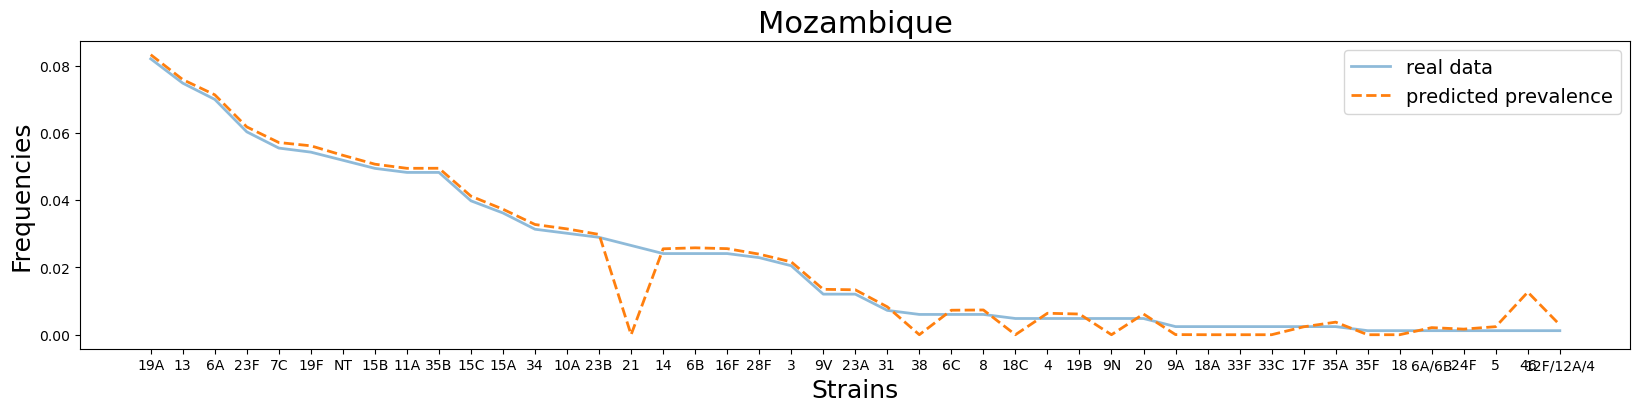

In [11]:
#FINAL TEST by data plot
range_strain = np.linspace(0, strain_number - 1, strain_number)
tick_label = np.array(Mozambique.strain)

fig = plt.figure(figsize = (20, 4))
plt.plot(range_strain, Mozambique_cases, '-', linewidth = 2, alpha =.5, label = 'real data')
plt.plot(range_strain, solution, '--', linewidth = 2, label = 'predicted prevalence')

plt.xlabel('Strains', fontsize = 18)
plt.ylabel('Frequencies', fontsize = 18)

plt.title('Mozambique', fontsize = 22)

plt.xticks(range_strain, labels = tick_label)
plt.legend(fontsize = 14)
plt.show()
#fig.savefig('Mozambique_estimate.png', dpi=300)

### Appendix: Test for equilibrium and its stability

0.034307483998984256


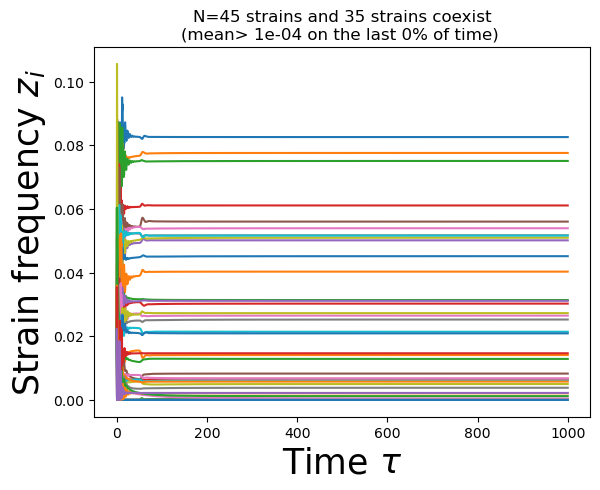

In [10]:
# compute the equilibrium of predicted model
one = np.ones(strain_number) #vector of all ones
result, ax = plot_dynamics(T = 1000, mu = 16.8, A = Mozambique_alpha, z0 = u0)

mu, A, fit, resultat, nc = simu(T = 300, mu = 16.8, A = Mozambique_alpha, z0 = u0)
error = np.linalg.norm(resultat.y[:,-1] - Mozambique_cases)
print(error)

In [11]:
# test stable equilibrium?
# test the equilibrium of predicted model
solution = resultat.y[:,-1]
RHS = (np.matmul(lambd, solution) - np.matmul(solution.T, np.matmul(lambd, solution)))*solution
error = np.linalg.norm(RHS)
print(error)

#compute error between observation data and equilibrium of predicted model

#compute Jacobian matrix with the equilibrium
jac = jacobian_func(lambd, solution)

#compute eigenvalues of Jacobian matrix
eigenvalues, eigenvectors = np.linalg.eig(jac)
real_eig = eigenvalues.real
eig = real_eig.tolist()
max_eig = max(eig)
print(max_eig)

8.124388289666379e-07
1.9202256059487968


In [12]:
print(eig)

positive_eig = [i for i in eig if i >= 0]
print(positive_eig, len(positive_eig))

[-9.168490089169673, -17.677328918856517, -0.2481383705830376, -0.2481383705830376, -0.19452982490919207, -0.19452982490919207, 1.9202256059487968, -0.18175892183697603, -0.18175892183697603, -2.9948454239040596, -1.9150749112165162, -1.1268724684499438, -0.18035981761758618, -0.18035981761758618, -0.5127644027711346, -0.5127644027711346, -0.6624868005625848, -0.334038431483597, -0.334038431483597, -0.43368955103058376, -0.43368955103058376, -0.524827673920957, -0.4971428068596406, -0.4971428068596406, -0.00831794864092054, -0.01825012036279323, -0.08117187496994649, -0.08117187496994649, -0.07080581727412934, -0.10306850388374862, -0.10306850388374862, -0.08351423912559826, -0.19201589831390348, -0.2306352519233259, -0.2306352519233259, -0.3277494975395619, -0.3277494975395619, -0.32896161324200607, -0.32896161324200607, -0.3015966862597578, -0.9996037286255117, -0.9255729536142631, -0.813385705937076, -0.7094166806917734, -0.4459609391808655]
[1.9202256059487968] 1


In [14]:
print(eig[6])
print(solution[6])

1.9202256059487968
0.053908202234553934


In [15]:
coexist_index = [i for i in range(0, 45) if solution[i] >= 1e-4]
print(coexist_index) #len = 35

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 28, 29, 31, 32, 36, 37, 41, 42, 43, 44]


In [19]:
sub_lambda = np.zeros((35, 35))
for i in range (0, 35):
    big_index_i = coexist_index[i]
    for j in range (0, 35):
        big_index_j = coexist_index[j]
        
        sub_lambda[i, j] = lambd[big_index_i, big_index_j]

In [20]:
coexist_solution = [i for i in solution if i >= 1e-4]

In [22]:
print(coexist_solution)

[0.0825565030809864, 0.07756012911002337, 0.07503408718428779, 0.06107311090669454, 0.05011777695742362, 0.05600342089377007, 0.053908202234553934, 0.05168748098402935, 0.05091937637621135, 0.051622537030210004, 0.04512609810343968, 0.04028990029128237, 0.03137387022770671, 0.030234977040637896, 0.031127659301375347, 0.026462632579990524, 0.02522022138049389, 0.027255637712383676, 0.021418610935168576, 0.020899800052306898, 0.01409645187612603, 0.01289020812179442, 0.006660334897416325, 0.008272073004795691, 0.0067256272841490945, 0.0049718269391032886, 0.005994503936869931, 0.005762309257345493, 0.0002461701195288543, 0.0005507668337770197, 0.0038039610951305074, 0.002075171694385033, 0.001207851140911877, 0.014653005940689018, 0.002197705475008579]


In [21]:
#compute Jacobian matrix with the equilibrium
sub_jac = jacobian_func(sub_lambda, coexist_solution)

#compute eigenvalues of Jacobian matrix
eigenvalues, eigenvectors = np.linalg.eig(sub_jac)
real_eig = eigenvalues.real
eig = real_eig.tolist()
max_eig = max(eig)
print(max_eig)

-0.008317948640773768
